In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import *

## Load and Preprocess Data

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

In [3]:
def generate_image_pairs_with_labels(images, classes):
    image_pairs = []
    labels = []
    sample = lambda x, s: x[np.random.choice(x.shape[0], s)]
    
    for i in range(10):
        similar = images[classes == i]
        non_similar = images[classes != i]
        size = similar.shape[0] // 2
        image_pairs.append([similar, np.concatenate([sample(similar, size), sample(non_similar, size)])])
        labels.append(np.concatenate([np.ones(size), np.zeros(size)]))
        
    image_pairs = np.concatenate(image_pairs, axis=1) / 255.0
    labels = np.concatenate(labels)
    indices = np.random.permutation(labels.shape[0])
    return image_pairs[:, indices], labels[indices]

In [4]:
train_image_pairs, train_labels = generate_image_pairs_with_labels(X_train, y_train)
test_image_pairs, test_labels = generate_image_pairs_with_labels(X_test, y_test)

In [135]:
def visualize_image_similarity(image_pairs, labels, examples=6, distances=None, threshold=0.5):
    x1, x2 = image_pairs
    i = np.random.randint(0, x1.shape[0] - examples)
    k = 1
    plt.figure(figsize=(5 * examples, 10))
    for img in x1[i : i + examples]:
        plt.subplot(2, examples, k)
        plt.imshow(img, cmap='gray')
        label = labels[i + k - 1]
        plt.title(label, fontdict={'fontsize': 50, 'color': 'r' if label < threshold else 'g'})
        k += 1
        plt.xticks([])
        plt.yticks([])
    for img in x2[i : i + examples]:
        plt.subplot(2, examples, k)
        plt.imshow(img, cmap='gray')
        if np.sum(distances) != None:
            dist = np.round(distances[i + k - 1][0], 4)
            plt.xlabel(dist, fontdict={'fontsize': 35, 'color': 'g' if dist < threshold else 'r'})
        k += 1
        plt.xticks([])
        plt.yticks([])

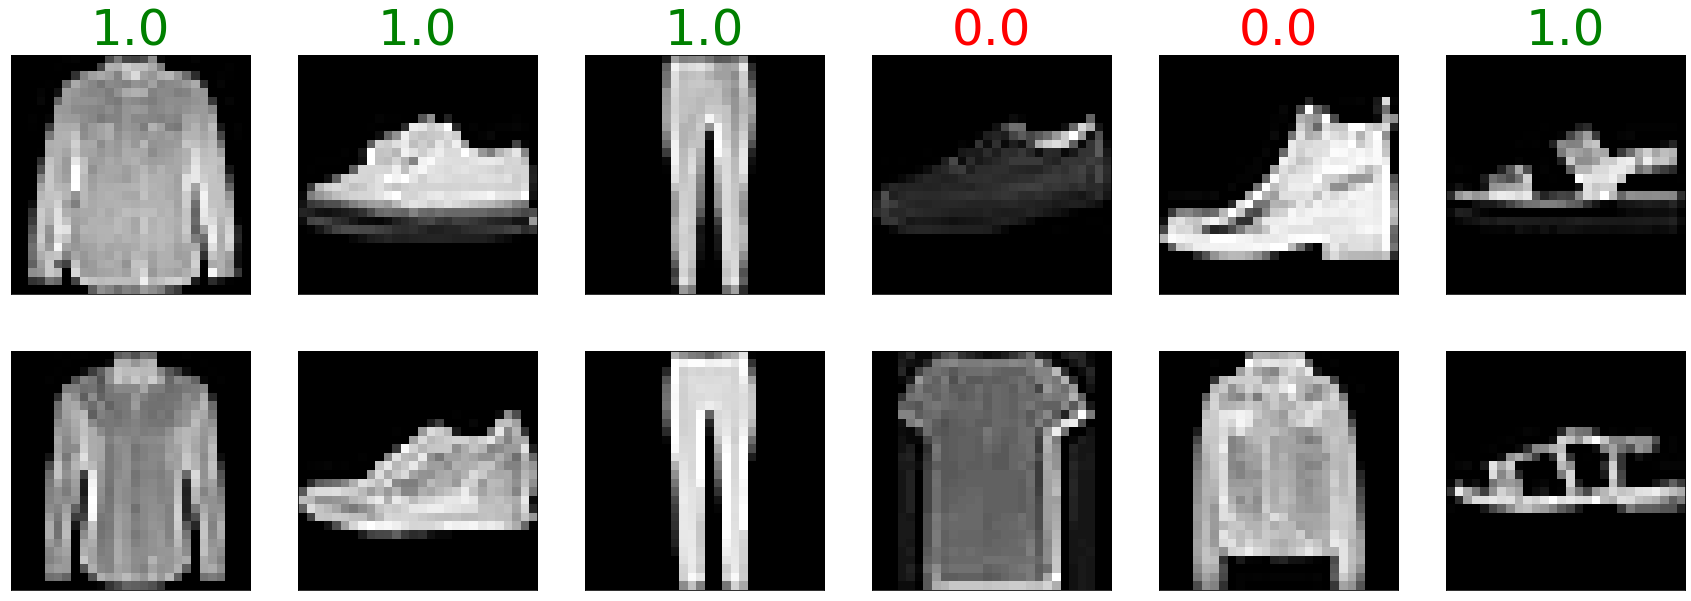

In [136]:
visualize_image_similarity(train_image_pairs, train_labels)

## Custom Loss as a Class

In [92]:
class ContrastiveLoss(losses.Loss):
    def __init__(self, margin=1):
        super().__init__()
        self.margin = margin
    
    def call(self, y_true, y_pred):
        margin_sq = tf.maximum(self.margin - y_pred, 0)
        return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(margin_sq))

## Custom Functions for Lambda Layers

In [93]:
def custom_relu(x):
    return tf.maximum(x, 0.01)

In [94]:
def euclidean_distance(vectors):
    x1, x2 = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x1 - x2), axis=-1, keepdims=True))

## Define Base Model

In [95]:
def initialise_base_model():
    x = layers.Input(shape=(28, 28), name='base_input')
    a = layers.Flatten()(x)
    a = layers.Dense(128, name='base_dense_1')(a)
    a = layers.Lambda(custom_relu, name='custom_relu_1')(a)
    a = layers.Dropout(0.1, name='dropout_1')(a)
    a = layers.Dense(128, name='base_dense_2')(a)
    a = layers.Lambda(custom_relu, name='custom_relu_2')(a)
    a = layers.Dropout(0.1, name='dropout_2')(a)
    a = layers.Dense(128, name='base_dense_3')(a)
    return models.Model(inputs=x, outputs=a)

In [96]:
base_model = initialise_base_model()

In [97]:
base_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 base_dense_1 (Dense)        (None, 128)               100480    
                                                                 
 custom_relu_1 (Lambda)      (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 base_dense_2 (Dense)        (None, 128)               16512     
                                                                 
 custom_relu_2 (Lambda)      (None, 128)               0   

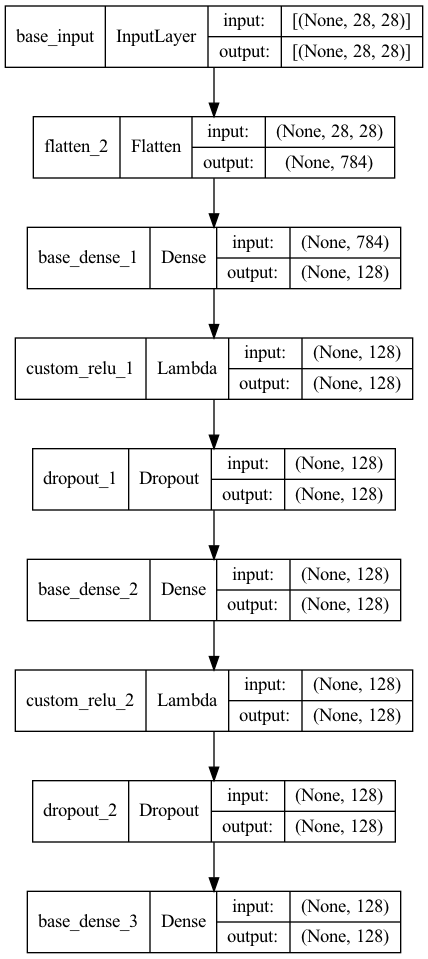

In [98]:
utils.plot_model(base_model, show_shapes=True)

## Siamese Network Architechture

In [99]:
input1 = layers.Input(shape=(28, 28), name='left_input')
input2 = layers.Input(shape=(28, 28), name='right_input')

In [100]:
output_vec1 = base_model(input1)
output_vec2 = base_model(input2)

In [101]:
distance = layers.Lambda(euclidean_distance, name='euclidean_distance')([output_vec1, output_vec2])

In [102]:
siamese_network = models.Model(inputs=[input1, input2], outputs=distance)

In [103]:
siamese_network.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128)          133504      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 euclidean_distance (Lambda)    (None, 1)            0           ['model_4[0][0]',          

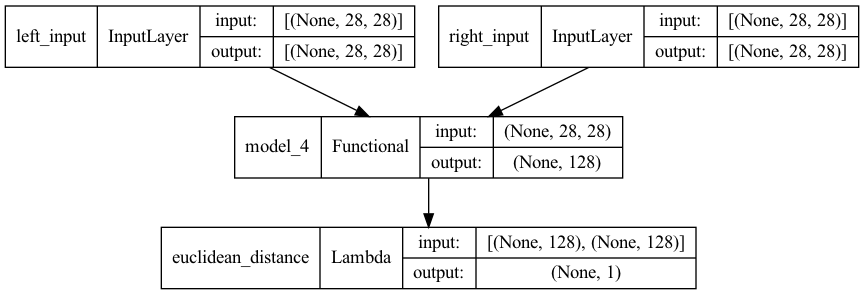

In [104]:
utils.plot_model(siamese_network, show_shapes=True)

## Training

In [105]:
optimizer = optimizers.RMSprop()
siamese_network.compile(optimizer=optimizer, loss=ContrastiveLoss())

In [106]:
history = siamese_network.fit([train_image_pairs[0, :], train_image_pairs[1, :]], train_labels, epochs=10, 
                              validation_data=([test_image_pairs[0, :], test_image_pairs[1, :]], test_labels))

Epoch 1/10
   1/1875 [..............................] - ETA: 17:51 - loss: 6.0162

2022-01-29 18:00:22.421094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.1435

2022-01-29 18:00:33.658232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 0.1435 - val_loss: 0.1084
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1091 - val_loss: 0.0962
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1028 - val_loss: 0.0907
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1000 - val_loss: 0.0914
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0976 - val_loss: 0.0918
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0954 - val_loss: 0.0909
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0935 - val_loss: 0.0901
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0923 - val_loss: 0.0874
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0919 - val_loss: 0.0886
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0891

## Evaluation